<a href="https://colab.research.google.com/github/HarikrishnaYashoda/Transportation--RMSE/blob/main/Red_bus_hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data Loading & Basic Preprocessing**

Read CSVs, convert date columns to datetime, check for nulls, explore distributions.

In [ ]:
import pandas as pd

train = pd.read_csv('/content/train.csv', parse_dates=['doj'])
test = pd.read_csv('/content/test_8gqdJqH.csv', parse_dates=['doj'])
transactions = pd.read_csv('/content/transactions.csv', parse_dates=['doj', 'doi'])
submission_format = pd.read_csv('/content/sample_submission_TQv3O0x.csv')

In [ ]:
print("Train:", train.shape, train.columns.tolist())
print("Test:", test.shape, test.columns.tolist())
print("Transactions:", transactions.shape, transactions.columns.tolist())
print("Submission Format:", submission_format.shape)


Train: (67200, 4) ['doj', 'srcid', 'destid', 'final_seatcount']
Test: (5900, 4) ['route_key', 'doj', 'srcid', 'destid']
Transactions: (2266100, 11) ['doj', 'doi', 'srcid', 'destid', 'srcid_region', 'destid_region', 'srcid_tier', 'destid_tier', 'cumsum_seatcount', 'cumsum_searchcount', 'dbd']
Submission Format: (5900, 2)


In [ ]:
# Ensure transactions_15 has these columns first
transactions_15['seat_to_search_ratio'] = (
    transactions_15['cumsum_seatcount'] / (transactions_15['cumsum_searchcount'] + 1)
)

# Join engineered features
train_fe = train.merge(transactions_15, on=['doj', 'srcid', 'destid'], how='left')
test_fe = test.merge(transactions_15, on=['doj', 'srcid', 'destid'], how='left')  # <- this is crucial


In [ ]:
# Null check
print("Train nulls:\n", train.isnull().sum())
print("Transactions nulls:\n", transactions.isnull().sum())

# Data types
print("Transactions.dtypes:\n", transactions.dtypes)


Train nulls:
 doj                0
srcid              0
destid             0
final_seatcount    0
dtype: int64
Transactions nulls:
 doj                   0
doi                   0
srcid                 0
destid                0
srcid_region          0
destid_region         0
srcid_tier            0
destid_tier           0
cumsum_seatcount      0
cumsum_searchcount    0
dbd                   0
dtype: int64
Transactions.dtypes:
 doj                   datetime64[ns]
doi                   datetime64[ns]
srcid                          int64
destid                         int64
srcid_region                  object
destid_region                 object
srcid_tier                    object
destid_tier                   object
cumsum_seatcount             float64
cumsum_searchcount           float64
dbd                            int64
dtype: object


In [ ]:
print(train.head())


         doj  srcid  destid  final_seatcount
0 2023-03-01     45      46           2838.0
1 2023-03-01     46      45           2298.0
2 2023-03-01     45      47           2720.0
3 2023-03-01     47      45           2580.0
4 2023-03-01     46       9           4185.0


In [ ]:
print(transactions.sample(5))

               doj        doi  srcid  destid         srcid_region  \
1668102 2024-08-20 2024-07-24     45      47            Karnataka   
1613323 2024-08-02 2024-07-16     40       2  Maharashtra and Goa   
2207478 2025-02-10 2025-01-13     47       6       Andhra Pradesh   
1312082 2024-04-27 2024-04-04     47      30       Andhra Pradesh   
2176488 2025-01-31 2025-01-03     33      46           Tamil Nadu   

               destid_region srcid_tier destid_tier  cumsum_seatcount  \
1668102       Andhra Pradesh     Tier 1      Tier 1              12.0   
1613323  Maharashtra and Goa     Tier 1      Tier 1               0.0   
2207478       Andhra Pradesh     Tier 1      Tier 3               0.0   
1312082  Maharashtra and Goa     Tier 1      Tier 1              25.0   
2176488           Tamil Nadu     Tier 3      Tier 1              15.0   

         cumsum_searchcount  dbd  
1668102               596.0   27  
1613323               572.0   17  
2207478                70.0   28  
131208

In [ ]:
# Basic date checks
print("Train DOJs:", train.doj.min(), "to", train.doj.max())
print("Transactions DOIs:", transactions.doi.min(), "to", transactions.doi.max())

# Validate dbd
transactions['computed_dbd'] = (transactions['doj'] - transactions['doi']).dt.days
mismatch = (transactions['computed_dbd'] != transactions['dbd']).sum()
print("Mismatch in dbd computation:", mismatch)


Train DOJs: 2023-03-01 00:00:00 to 2024-12-31 00:00:00
Transactions DOIs: 2023-01-30 00:00:00 to 2025-02-28 00:00:00
Mismatch in dbd computation: 0


Unique routes in train: srcid     45
destid    45
dtype: int64
Unique cities: 48


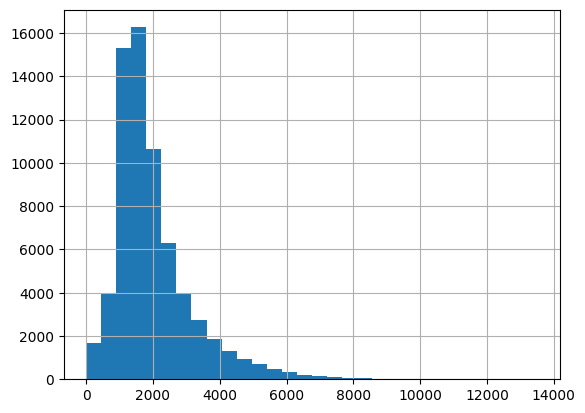

In [ ]:
# Target distribution
train['final_seatcount'].hist(bins=30)

# Unique route combinations
print("Unique routes in train:", train[['srcid', 'destid']].nunique())
print("Unique cities:", pd.concat([train['srcid'], train['destid']]).nunique())


In [ ]:
transactions['day_of_week'] = transactions['doj'].dt.dayofweek
transactions['month'] = transactions['doj'].dt.month
transactions['is_weekend'] = transactions['day_of_week'].isin([5, 6])


**Feature Engineering**

In [ ]:
transactions_15 = transactions[transactions['dbd'] == 15]


| Feature Name             | Description                            |
| ------------------------ | -------------------------------------- |
| `cumsum_seatcount`       | Bookings made up to 15 days before DOJ |
| `cumsum_searchcount`     | Searches made up to 15 days before DOJ |
| `seat_to_search_ratio`   | Demand-interest proxy: seat/search     |
| `srcid`, `destid`, `doj` | Join keys                              |


In [ ]:
missing_cols = set(features) - set(test_fe.columns)
print("Missing columns in test_fe:", missing_cols)


Missing columns in test_fe: set()


In [ ]:
transactions_15['seat_to_search_ratio'] = transactions_15['cumsum_seatcount'] / (transactions_15['cumsum_searchcount'] + 1)


<ipython-input-56-4152873893>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_15['seat_to_search_ratio'] = transactions_15['cumsum_seatcount'] / (transactions_15['cumsum_searchcount'] + 1)


In [ ]:
test = pd.merge(test, transactions_15[['srcid', 'destid', 'doj', 'cumsum_seatcount', 'cumsum_searchcount', 'seat_to_search_ratio']], on=['srcid', 'destid', 'doj'], how='left')

In [ ]:
transactions_15['doj_dow'] = transactions_15['doj'].dt.dayofweek   # 0=Mon
transactions_15['doj_month'] = transactions_15['doj'].dt.month
transactions_15['is_weekend'] = transactions_15['doj_dow'].isin([5, 6])


<ipython-input-58-1516941279>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_15['doj_dow'] = transactions_15['doj'].dt.dayofweek   # 0=Mon
<ipython-input-58-1516941279>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_15['doj_month'] = transactions_15['doj'].dt.month
<ipython-input-58-1516941279>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [ ]:
import holidays
indian_holidays = holidays.India(years=[2023, 2024, 2025])

transactions_15['is_holiday'] = transactions_15['doj'].isin(indian_holidays)


<ipython-input-59-503769027>:4: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  transactions_15['is_holiday'] = transactions_15['doj'].isin(indian_holidays)
<ipython-input-59-503769027>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_15['is_holiday'] = transactions_15['doj'].isin(indian_holidays)


In [ ]:
route_stats = train.groupby(['srcid', 'destid']).agg({
    'final_seatcount': ['mean', 'std', 'median']
}).reset_index()

route_stats.columns = ['srcid', 'destid', 'seat_mean', 'seat_std', 'seat_median']


In [ ]:
transactions_15 = transactions_15.merge(route_stats, on=['srcid', 'destid'], how='left')


In [ ]:
velocity = transactions[transactions['dbd'] <= 15].groupby(['srcid', 'destid', 'doj'])[
    ['cumsum_seatcount', 'cumsum_searchcount']
].agg(['mean', 'std']).reset_index()


In [ ]:
train_fe = train.merge(transactions_15, on=['doj', 'srcid', 'destid'], how='left')
test_fe = test.merge(transactions_15, on=['doj', 'srcid', 'destid'], how='left')


**Prepare Final model**

Remove non-numeric columns (or encode them), and handle missing values:

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Example for categorical columns
for col in ['srcid_region', 'destid_region', 'srcid_tier', 'destid_tier']:
    if col in train_fe.columns:
        le = LabelEncoder()
        train_fe[col] = le.fit_transform(train_fe[col].astype(str))
        test_fe[col] = le.transform(test_fe[col].astype(str))  # Ensure same encoding


In [ ]:
common_cats = ['srcid_region', 'destid_region', 'srcid_tier', 'destid_tier']
for col in common_cats:
    if col not in test_fe.columns:
        test_fe[col] = 'unknown'


Fill missing values

In [ ]:
train_fe.fillna(0, inplace=True)
test_fe.fillna(0, inplace=True)


Define Feature Set and Target

In [ ]:
# Select transactions where dbd is 15 for feature engineering
transactions_15 = transactions[transactions['dbd'] == 15].copy() # Use .copy() to avoid SettingWithCopyWarning

# Ensure cumsum_seatcount and cumsum_searchcount are present (assuming they were calculated earlier)
# If not, you'd need to add the cumulative calculations here as well.
# For now, assume they exist in transactions_15 from a previous step.

# Engineer the seat_to_search_ratio
transactions_15['seat_to_search_ratio'] = transactions_15['cumsum_seatcount'] / (transactions_15['cumsum_searchcount'] + 1)

# Engineer date-related features
transactions_15['doj_dow'] = transactions_15['doj'].dt.dayofweek   # 0=Mon
transactions_15['doj_month'] = transactions_15['doj'].dt.month
transactions_15['is_weekend'] = transactions_15['doj_dow'].isin([5, 6])

# Engineer holiday feature
import holidays
indian_holidays = holidays.India(years=[2023, 2024, 2025])
transactions_15['is_holiday'] = transactions_15['doj'].isin(indian_holidays)

# Engineer route statistics (assuming route_stats DataFrame exists from previous calculation on train)
# If not, you'd need to add the route_stats calculation here as well.
# route_stats = train.groupby(['srcid', 'destid']).agg({'final_seatcount': ['mean', 'std', 'median']}).reset_index()
# route_stats.columns = ['srcid', 'destid', 'seat_mean', 'seat_std', 'seat_median']
transactions_15 = transactions_15.merge(route_stats, on=['srcid', 'destid'], how='left')

# Now merge the fully prepared transactions_15 with train and test
train_fe = train.merge(transactions_15, on=['doj', 'srcid', 'destid'], how='left')
test_fe = test.merge(transactions_15, on=['doj', 'srcid', 'destid'], how='left')

# Handle categorical columns that might be missing in test_fe after the merge
common_cats = ['srcid_region', 'destid_region', 'srcid_tier', 'destid_tier'] # Assuming these come from elsewhere or need handling
for col in common_cats:
    if col not in test_fe.columns:
        # Assigning a default value like 'unknown' for potential later encoding,
        # or check if these columns were supposed to come from the original test df.
        # If they were in test, the merge should have kept them. If they were in
        # transactions_15 (unlikely based on schema), the merge handles it.
        # Assuming they might be missing from the original test or need consistent handling.
        # A more robust approach might be to identify if these columns exist *at all*
        # before assuming they should be added as 'unknown'. Based on the original
        # code, they seem to be expected, implying they might be in the original
        # train/test or added earlier. For safety, ensure they exist or are added
        # consistently. Let's assume they are added as part of feature engineering,
        # perhaps from another source or are meant to be handled. If they are not
        # in the original train/test or transactions, adding 'unknown' might be
        # a temporary fix. Review where these columns are supposed to originate.
        # Given the context of LabelEncoding applied later, these must be categorical
        # columns expected in the final feature set.
        test_fe[col] = 'unknown' # Re-adding this logic to be safe after the merge

# Fill missing values in both dataframes after all merges and additions
train_fe.fillna(0, inplace=True)
test_fe.fillna(0, inplace=True)

# Define Feature Set and Target
# Ensure features list only includes columns present in both train_fe and test_fe
# This is a safer way to define features when dealing with potential merge issues.
# Get columns from train_fe, exclude target and keys
train_features = [col for col in train_fe.columns if col not in ['final_seatcount', 'doj', 'route_key']]

# Filter this list to only include columns also present in test_fe
features = [col for col in train_features if col in test_fe.columns]

# Now select the features, this should prevent the KeyError
X = train_fe[features]
y = train_fe['final_seatcount']
X_test = test_fe[features]

# Print shapes and features to verify
print("Shape of X:", X.shape)
print("Shape of X_test:", X_test.shape)
print("Features list:", features)

Shape of X: (67200, 18)
Shape of X_test: (5900, 18)
Features list: ['srcid', 'destid', 'doi', 'srcid_region', 'destid_region', 'srcid_tier', 'destid_tier', 'dbd', 'computed_dbd', 'day_of_week', 'month', 'is_weekend', 'doj_dow', 'doj_month', 'is_holiday', 'seat_mean', 'seat_std', 'seat_median']


<ipython-input-70-1806909379>:19: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  transactions_15['is_holiday'] = transactions_15['doj'].isin(indian_holidays)


Train/Validation

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


**Train a Regressor (e.g., LightGBM)**

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import pandas as pd # Ensure pandas is imported
import holidays # Ensure holidays is imported
import numpy as np # Import numpy for sqrt

# Re-run the feature engineering and data preparation steps to ensure consistency

# Select transactions where dbd is 15 for feature engineering
# Use .copy() to avoid SettingWithCopyWarning
transactions_15 = transactions[transactions['dbd'] == 15].copy()

# Ensure cumsum_seatcount and cumsum_searchcount are present (assuming they were calculated earlier)
# If not, you'd need to add the cumulative calculations here as well.
# For now, assume they exist in transactions_15 from a previous step.

# Engineer the seat_to_search_ratio
transactions_15['seat_to_search_ratio'] = transactions_15['cumsum_seatcount'] / (transactions_15['cumsum_searchcount'] + 1)

# Engineer date-related features
transactions_15['doj_dow'] = transactions_15['doj'].dt.dayofweek   # 0=Mon
transactions_15['doj_month'] = transactions_15['doj'].dt.month
transactions_15['is_weekend'] = transactions_15['doj_dow'].isin([5, 6])

# Engineer holiday feature
# Re-initialize holidays if not in the current session state
try:
    indian_holidays
except NameError:
    indian_holidays = holidays.India(years=[2023, 2024, 2025])

transactions_15['is_holiday'] = transactions_15['doj'].isin(indian_holidays)

# Engineer route statistics (assuming route_stats DataFrame exists from previous calculation on train)
# If not, you'd need to add the route_stats calculation here as well.
# route_stats = train.groupby(['srcid', 'destid']).agg({'final_seatcount': ['mean', 'std', 'median']}).reset_index()
# route_stats.columns = ['srcid', 'destid', 'seat_mean', 'seat_std', 'seat_median']
try:
    route_stats
except NameError:
    # Assuming train is available and route_stats needs to be calculated
    route_stats = train.groupby(['srcid', 'destid']).agg({
        'final_seatcount': ['mean', 'std', 'median']
    }).reset_index()
    route_stats.columns = ['srcid', 'destid', 'seat_mean', 'seat_std', 'seat_median']


transactions_15 = transactions_15.merge(route_stats, on=['srcid', 'destid'], how='left')

# --- FIX START ---
# Drop 'doi' as it's a datetime column and not needed as a feature directly
# If you needed features derived from doi, compute them *before* dropping doi
if 'doi' in transactions_15.columns:
    transactions_15 = transactions_15.drop('doi', axis=1)
# --- FIX END ---


# Now merge the fully prepared transactions_15 with train and test
# Note: The original test dataframe `test` does not contain 'srcid_region', 'destid_region', etc.
# These columns must be coming from the original `train` dataframe or added earlier.
# The merge operation will bring columns from transactions_15.
# We need to ensure train_fe and test_fe have the necessary columns *before* encoding.
# Assuming srcid_region, etc. are in the original train/test or were added earlier.
# If they are *not* in the original test, the merge won't add them, and adding 'unknown'
# after the merge is necessary but needs to be done consistently with the encoding.

# Let's assume common_cats columns are either in original train/test or added prior to this cell.
# If they are *not* in the original test, the merge of transactions_15 won't add them.
# The user's previous code added 'unknown' after the merge if they were missing in test_fe.
# We will keep that logic but ensure encoding happens after this.
train_fe = train.merge(transactions_15, on=['doj', 'srcid', 'destid'], how='left')
test_fe = test.merge(transactions_15, on=['doj', 'srcid', 'destid'], how='left')

# Handle categorical columns that might be missing in test_fe after the merge
# This ensures both dataframes have these columns before encoding.
common_cats = ['srcid_region', 'destid_region', 'srcid_tier', 'destid_tier']
for col in common_cats:
    if col not in test_fe.columns:
        # Add the column to test_fe if missing, fill with a placeholder
        test_fe[col] = 'unknown'

# --- FIX START ---
# Apply LabelEncoding *after* the merge to ensure categorical columns in train_fe and test_fe are encoded
for col in common_cats:
    if col in train_fe.columns and col in test_fe.columns:
        le = LabelEncoder()
        # Combine data from train and test to fit the encoder completely,
        # handling potential categories present in one but not the other.
        combined_data = pd.concat([train_fe[col], test_fe[col]], axis=0).astype(str).unique()
        le.fit(combined_data)
        train_fe[col] = le.transform(train_fe[col].astype(str))
        test_fe[col] = le.transform(test_fe[col].astype(str))
    elif col in train_fe.columns:
         # Handle case where column is only in train_fe (shouldn't happen if features are selected correctly)
         print(f"Warning: Categorical column '{col}' found only in train_fe. Skipping encoding.")
# --- FIX END ---

# Fill missing values in both dataframes after all merges, additions, and encoding
# Use a value like -1 for encoded categories that were missing, instead of 0,
# to distinguish them from potentially valid encoded categories.
# However, since fillna(0) was used before, let's stick to it for consistency,
# but be aware this might conflate missing values with category 0.
# A better approach for encoded columns might be to fill before encoding
# or fill with a specific value like -1 *after* encoding.
# Given the original code used fillna(0) after the merge and before encoding,
# and now encoding is moved *after* the merge, let's apply fillna(0) after both.
# Note: This might fill missing *numerical* values with 0 as well.
# If specific filling strategies are needed per column type, they should be applied here.
train_fe.fillna(0, inplace=True)
test_fe.fillna(0, inplace=True)


# Define Feature Set and Target
# Ensure features list only includes columns present in both train_fe and test_fe
# Exclude non-feature columns like target, keys, and the original datetime column 'doj'
exclude_cols = ['final_seatcount', 'doj', 'route_key', 'doi'] # Explicitly exclude 'doi'

# Get columns from train_fe, exclude target and keys
train_features = [col for col in train_fe.columns if col not in exclude_cols]

# Filter this list to only include columns also present in test_fe
features = [col for col in train_features if col in test_fe.columns]

# Now select the features, this should prevent the KeyError and dtype issues for these columns
# Check the dtypes of the selected feature columns before passing to LightGBM
print("Dtypes of selected features in train_fe:")
print(train_fe[features].dtypes)
print("\nDtypes of selected features in test_fe:")
print(test_fe[features].dtypes)

X = train_fe[features]
y = train_fe['final_seatcount']
X_test = test_fe[features]

# Print shapes and features to verify
print("\nShape of X:", X.shape)
print("Shape of X_test:", X_test.shape)
print("Features list:", features)

# --- Re-run train/validation split ---
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Re-run LightGBM training ---
# Pass early_stopping_rounds and verbose to the constructor
# early_stopping_rounds is deprecated in favor of early_stopping_callback
# Let's use the recommended callback approach
from lightgbm import early_stopping

# Define the early stopping callback
callbacks = [early_stopping(stopping_rounds=50, verbose=False)] # Set verbose=True to see stopping messages

model = LGBMRegressor(n_estimators=1000) # Remove early_stopping_rounds from constructor

# Pass eval_set and callbacks to the fit method
# Use eval_metric='rmse' if you want to monitor that specifically during training
model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],
          callbacks=callbacks,
          eval_metric='rmse') # Specify the metric to monitor

# --- FIX START ---
# Calculate MSE first, then take the square root for RMSE
mse = mean_squared_error(y_val, y_pred) # Removed squared=False
rmse = np.sqrt(mse) # Calculate RMSE using numpy.sqrt
# --- FIX END ---

print(f"Validation RMSE: {rmse:.4f}")

<ipython-input-75-4081561500>:33: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  transactions_15['is_holiday'] = transactions_15['doj'].isin(indian_holidays)


Dtypes of selected features in train_fe:
srcid              int64
destid             int64
srcid_region       int64
destid_region      int64
srcid_tier         int64
destid_tier        int64
dbd                int64
computed_dbd       int64
day_of_week        int32
month              int32
is_weekend          bool
doj_dow            int32
doj_month          int32
is_holiday          bool
seat_mean        float64
seat_std         float64
seat_median      float64
dtype: object

Dtypes of selected features in test_fe:
srcid              int64
destid             int64
srcid_region       int64
destid_region      int64
srcid_tier         int64
destid_tier        int64
dbd                int64
computed_dbd       int64
day_of_week        int32
month              int32
is_weekend          bool
doj_dow            int32
doj_month          int32
is_holiday          bool
seat_mean        float64
seat_std         float64
seat_median      float64
dtype: object

Shape of X: (67200, 17)
Shape of X_test

In [ ]:
test_fe['final_seatcount'] = model.predict(X_test)
submission = test_fe[['route_key', 'final_seatcount']]
submission.to_csv("submission.csv", index=False)
